In [1]:
import numpy as np
import cv2
import pandas as pd
from shapely.wkt import loads as wkt_loads
import tifffile as tiff

In [2]:
print('importing DL libraries')
import tensorflow.keras as keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

importing DL libraries


In [3]:

def unet(pretrained_weights = None,input_size = (256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model
# model = unet(input_size=(1024,1024,3))


In [4]:
# inp = Input(shape=(1024,1024,3),name='input_image')
# #[TO:DO] check why (28,28,1) instead of (28,28)
# hl1 = Conv2D(filters=32,kernel_size=(3,3),activation='relu',name='conv3x3_hl1',padding='same')(inp)
# hl2 = Conv2D(filters=40,kernel_size=(3,3),activation='relu',name='conv3x3_hl4',padding='same')(hl1)
# out = Conv2D(filters=1,kernel_size=(3,3),activation='sigmoid',name='conv3x3_output', padding='same')(hl2)


# model = keras.models.Model(inp,out)
# model = unet(input_size=(1024,1024,3))
# model.summary()

# model.compile(loss='binary_crossentropy',
#       optimizer= 'Adam' ,
#       metrics=['accuracy'])


''' model = unet(input_size=(1024,1024,3))

model.summary()

model.compile(loss='binary_crossentropy',
      optimizer= 'Adam' ,
      metrics=['accuracy'])
'''


In [5]:
def _get_image_names(base_path, imageId):
    '''
    Get the names of the tiff files
    '''
    d = {'3': path.join(base_path,'three_band/{}.tif'.format(imageId)),             # (3, 3348, 3403)
         'A': path.join(base_path,'sixteen_band/{}_A.tif'.format(imageId)),         # (8, 134, 137)
         'M': path.join(base_path,'sixteen_band/{}_M.tif'.format(imageId)),         # (8, 837, 851)
         'P': path.join(base_path,'sixteen_band/{}_P.tif'.format(imageId)),         # (3348, 3403)
         }
    return d


def _convert_coordinates_to_raster(coords, img_size, xymax):
    Xmax,Ymax = xymax
    H,W = img_size
    W1 = 1.0*W*W/(W+1)
    H1 = 1.0*H*H/(H+1)
    xf = W1/Xmax
    yf = H1/Ymax
    coords[:,1] *= yf
    coords[:,0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int


def _get_xmax_ymin(grid_sizes_panda, imageId):
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0,1:].astype(float)
    return (xmax,ymin)


def _get_polygon_list(wkt_list_pandas, imageId, cType):
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList


def _get_and_convert_contours(polygonList, raster_img_size, xymax):
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list,interior_list


def _plot_mask_from_contours(raster_img_size, contours, class_value = 1):
    img_mask = np.zeros(raster_img_size,np.uint8)
    if contours is None:
        return img_mask
    perim_list,interior_list = contours
    cv2.fillPoly(img_mask,perim_list,class_value)
    cv2.fillPoly(img_mask,interior_list,0)
    return img_mask


def generate_mask_for_image_and_class(raster_size, imageId, class_type, grid_sizes_panda,
                                     wkt_list_pandas):
    xymax = _get_xmax_ymin(grid_sizes_panda,imageId)
    polygon_list = _get_polygon_list(wkt_list_pandas,imageId,class_type)
    contours = _get_and_convert_contours(polygon_list,raster_size,xymax)
    mask = _plot_mask_from_contours(raster_size,contours,1)
    return mask





def scale_percentile(matrix):
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    matrix = (matrix - mins[None, :]) / maxs[None, :]
    matrix = np.reshape(matrix, [w, h, d])
    matrix = matrix.clip(0, 1)
    return matrix






In [17]:
def get_bfiles(path,files,gs,df):
    bfiles=[]
    for file in files:
        img_rgb = tiff.imread(path+file).transpose([1, 2, 0])
        mask = generate_mask_for_image_and_class((img_rgb.shape[0], img_rgb.shape[1]),file.split('.')[0],1,gs,df)
#         print(np.sum(mask>0))
        if np.sum(mask>0) > 100:
            bfiles.append(file)
#             print(file,' is worth it')
    return bfiles   

In [7]:
def image_generator_3x3(path,files,gs,df, batch_size = 2):
	count= -batch_size
	length=len(files)
# 	y=np.expand_dims(y, axis=3)
	while True:
		#keeping count to avoid outof bound error
		count+=batch_size
		if(count>=length- batch_size):
			count=0
		batch_input = []
		batch_mask = [] 

		
		for i in range(batch_size):
			# Read the Big Image and crop it
			img_rgb = tiff.imread(path+files[count+i]).transpose([1, 2, 0])
			mask = generate_mask_for_image_and_class((img_rgb.shape[0], img_rgb.shape[1]),files[count+i].split('.')[0],1,gs,df)                
			img_rgb = img_rgb[:3072,:3072]
			mask = mask[:3072,:3072]
			mask=np.expand_dims(mask, axis=3)
# 			iimggg = np.concatenate((img_rgb[:,:,0],mask[:,:,0]*255),axis = 1)
# 			tiff.imshow(iimggg);
# 			print('non zero pixels',np.sum(mask>0))
			# cropping into different parts
			for j in range(3):
				for k in range(3):
					batch_input += [ img_rgb[k*1024:k*1024+1024,j*1024:j*1024+1024] ]
					batch_mask += [ mask[k*1024:k*1024+1024,j*1024:j*1024+1024] ]
					batch_mask = np.array( batch_mask )
					batch_input = np.array( batch_input )
# 					print(batch_input[0][:,:,0].shape,batch_mask[0][:,:,0].shape)
					                    
					yield( batch_input , batch_mask )
					batch_input = []
					batch_mask = []                 
		# Return a tuple of (input,output) to feed the network
# 		batch_input = np.array( batch_input )
# 		batch_mask = np.array( batch_mask )

# 		yield( batch_input , batch_mask )

In [8]:
# don't think I need this function
def show_shuff(path,files,gs,df, batch_size = 2):
	count= -batch_size
	length=len(files)
# 	y=np.expand_dims(y, axis=3)
	while True:
		#keeping count to avoid outof bound error
		count+=batch_size
		if(count>=length- batch_size):
			count=0
		batch_input = []
		batch_mask = [] 

		
		for i in range(batch_size):
			# Read the Big Image and crop it
			img_rgb = tiff.imread(path+files[count+i]).transpose([1, 2, 0])
			mask = generate_mask_for_image_and_class((img_rgb.shape[0], img_rgb.shape[1]),files[count+i].split('.')[0],1,gs,df)
			img_rgb = img_rgb[:3072,:3072]
			mask = mask[:3072,:3072]
			mask=np.expand_dims(mask, axis=3)
			# cropping into different parts
			for j in range(3):
				for k in range(3):
					batch_input += [ img_rgb[k*1024:k*1024+1024,j*1024:j*1024+1024] ]
					batch_mask += [ mask[k*1024:k*1024+1024,j*1024:j*1024+1024] ]
					batch_mask = np.array( batch_mask )
					batch_input = np.array( batch_input )
					print(batch_input[0][:,:,0].shape,batch_mask[0][:,:,0].shape)
					iimggg = np.concatenate((batch_input[0][:,:,0],batch_mask[0][:,:,0]),axis = 1)
# 					cv2.imshow('example',iimggg)
					tiff.imshow(iimggg);                    
					yield iimggg
# 					batch_input = []
# 					batch_mask = []                

In [9]:
def image_generator_1x1(path,files,gs,df, batch_size = 9):
	count= -batch_size
	length=len(files)
# 	y=np.expand_dims(y, axis=3)
	while True:
		#keeping count to avoid outof bound error
		count+=batch_size
		if(count>=length- batch_size):
			count=0
		batch_input = []
		batch_mask = [] 

		
		for i in range(batch_size):
			# Read the Big Image and crop it
			img_rgb = tiff.imread(path+files[count+i]).transpose([1, 2, 0])
			mask = generate_mask_for_image_and_class((img_rgb.shape[0], img_rgb.shape[1]),files[count+i].split('.')[0],1,gs,df)
			img_rgb = img_rgb[:3072,:3072]
			mask = mask[:3072,:3072]
			mask=np.expand_dims(mask, axis=3)
			
			# cropping into different parts
			img_rgb = cv2.resize(img_rgb,(1024,1024))
			mask = cv2.resize(mask,(1024,1024))
			batch_input += [ img_rgb ]
			batch_mask += [ mask ]
			
		# Return a tuple of (input,output) to feed the network
		batch_input = np.array( batch_input )
		batch_mask = np.array( batch_mask )

		yield( batch_input , batch_mask )

In [10]:
def image_generator_6x6(path,files,gs,df, batch_size = 1):
	count= -batch_size
	length=len(files)
# 	y=np.expand_dims(y, axis=3)
	while True:
		#keeping count to avoid outof bound error
		count+=batch_size
		if(count>=length- batch_size):
			count=0
		batch_input = []
		batch_mask = [] 

		
		for i in range(batch_size):
			# Read the Big Image and crop it
			img_rgb = tiff.imread(path+files[count+i]).transpose([1, 2, 0])
			mask = generate_mask_for_image_and_class((img_rgb.shape[0], img_rgb.shape[1]),files[count+i].split('.')[0],1,gs,df)                
			img_rgb = img_rgb[:3072,:3072]
			mask = mask[:3072,:3072]
			mask=np.expand_dims(mask, axis=3)
# 			iimggg = np.concatenate((img_rgb[:,:,0],mask[:,:,0]*255),axis = 1)
# 			tiff.imshow(iimggg);
# 			print('non zero pixels',np.sum(mask>0))
			# cropping into different parts
			for j in range(6):
				for k in range(6):
					batch_input += [ img_rgb[k*512:k*512+512,j*512:j*512+512] ]
					batch_mask += [ mask[k*512:k*512+512,j*512:j*512+512] ]
					batch_mask = np.array( batch_mask )
					batch_input = np.array( batch_input )
# 					print(batch_input[0][:,:,0].shape,batch_mask[0][:,:,0].shape)
					                    
					yield( batch_input , batch_mask )
					batch_input = []
					batch_mask = [] 
                    
# 		yield( batch_input , batch_mask )

In [11]:
from os import listdir
from os.path import isfile, join


In [12]:

inDir = '../input/dstl-satellite-imagery-feature-detection/'


# read the training data from train_wkt_v4.csv
df = pd.read_csv(inDir + '/train_wkt_v4.csv')

# grid size will also be needed later..
gs = pd.read_csv(inDir + '/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
inDir = '../input/dstl-satellite-imagery-feature-detection/three_band/'

In [17]:
# files = [f for f in listdir(inDir) if isfile(join(inDir, f))]
# bfiles = get_bfiles(inDir,files,gs,df)

In [18]:
# file_1=np.array(files)
# print(file_1.shape)
# bfiles=np.array(bfiles)
# np.save('bfiles',bfiles)
# print(bfiles.shape)
# bfiles=np.load('bfiles.npy')
# print(bfiles.shape)

In [19]:
bfiles = np.load('bfiles.npy')
# print(bfiles.shape)


In [20]:
# img = show_shuff(inDir,files,gs,df,)

In [21]:
# img.shape
# # cv2.imshow('life is strange',img/767*255)
# tiff.imshow(img());
# # print(img)

In [22]:
# print("batch Size",bs)
model = unet(input_size=(1024,1024,3))
# model.summary()
ig= image_generator_3x3(inDir,bfiles,gs,df,2)
H = model.fit_generator(ig,steps_per_epoch=100)


# model.compile(loss='binary_crossentropy',
#       optimizer= 'Adam' ,
#       metrics=['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


100/100 [==============================] - 357s 3.5s/step - loss: 1.3211 - acc: 0.8380


In [23]:
print('Now our architecture')

tfiles=['6120_2_2.tif']

Now our architecture


In [24]:
model1=  unet(input_size=(512,512,3))
ig1= image_generator_6x6(inDir,bfiles,gs,df,1)
H1 = model1.fit_generator(ig1,steps_per_epoch=100*4)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


400/400 [==============================] - 222s 555ms/step - loss: 1.6886 - acc: 0.8137


In [25]:
model2=  unet(input_size=(1024,1024,3))
ig2= image_generator_3x3(inDir,bfiles,gs,df,1)
H2 = model2.fit_generator(ig2,steps_per_epoch=100)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


100/100 [==============================] - 361s 3.6s/step - loss: 1.3607 - acc: 0.8360


In [26]:
model3=  unet(input_size=(1024,1024,3))
ig3= image_generator_1x1(inDir,bfiles,gs,df,1)
H3 = model3.fit_generator(ig3,steps_per_epoch=100)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


100/100 [==============================] - 154s 1.54s/step - loss: 2.4356 - acc: 0.8209


In [27]:
def cropNstich(img,model,ratio):
    #Crop Image
    d=int(3072/ratio)
#     print(d)
    
    imgs = []
    for j in range(ratio):
        for k in range(ratio):
            imgs.append(img[k*d:k*d+d,j*d:j*d+d])
    imgs=np.array(imgs)
    #Feed to Network
    preds=model.predict(imgs)
    
    pred = np.zeros(shape=(3072,3072,1),dtype=float)
    for j in range(ratio):
        for k in range(ratio):
            pred[k*d:k*d+d,j*d:j*d+d]=preds[j*ratio+k]
#     pred[pred>0]=255
    #Stich Back together
    return pred
    #Return

In [28]:
img_test=tiff.imread('../input/dstl-satellite-imagery-feature-detection/three_band/6120_2_2.tif').transpose([1, 2, 0])
mask1=cropNstich(img_test,model1,6)
mask2=cropNstich(img_test,model2,3)

imgs=[]
imgs.append([cv2.resize(img_test[:3072,:3072],(1024,1024))])
mask3=model3.predict(imgs)
mask3=cv2.resize(mask3[0],(3072,3072))
# print()


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [29]:
print(mask1.shape,mask2.shape,mask3.shape)
mask = mask1[:,:,0]+mask2[:,:,0]+mask3
mask[mask>0] = 255

(3072, 3072, 1) (3072, 3072, 1) (3072, 3072)


(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f4c32ae7fd0>)

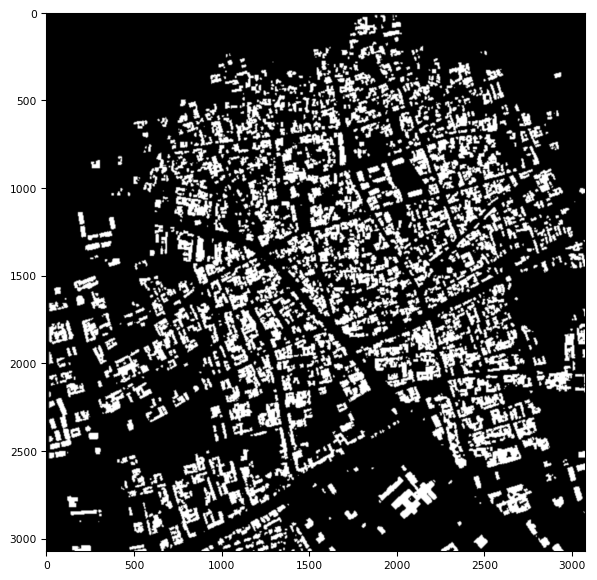

In [30]:
tiff.imshow(mask)

In [ ]:
# def show_stuff(path,files,gs,df, batch_size = 2):
# 	count= -batch_size
# 	length=len(files)
# # 	y=np.expand_dims(y, axis=3)
# 	while True:
# 		#keeping count to avoid outof bound error
# 		count+=batch_size
# 		if(count>=length- batch_size):
# 			count=0
# 		batch_input = []
# 		batch_mask = [] 

		
# 		for i in range(1):
# 			# Read the Big Image and crop it
# 			img_rgb = tiff.imread(path+files[1]).transpose([1, 2, 0])
# 			mask = generate_mask_for_image_and_class((img_rgb.shape[0], img_rgb.shape[1]),files[1].split('.')[0],1,gs,df)
# 			img_rgb = img_rgb[:3072,:3072]
# 			mask = mask[:3072,:3072]
# 			mask=np.expand_dims(mask, axis=3)
# 			# cropping into different parts
# 			for j in range(3):
# 				for k in range(3):
# 					batch_input += [ img_rgb[k*1024:k*1024+1024,j*1024:j*1024+1024] ]
# 					batch_mask += [ mask[k*1024:k*1024+1024,j*1024:j*1024+1024] ]
# 					return ( batch_input , batch_mask )                    

# bi,bm=show_stuff(inDir,files,gs,df)

In [ ]:
# bi=np.array(bi)
# bi.shape